# Experimento 02

---
En este pipeline, se prueba la eficiencia de 4 métodos diferentes que implementan el sistema de ecuaciones diferenciales de un modelo SIR con movimiento Lagrangiano para su evaluación en el algoritmo de resolución numérica `solve_ivp` de `scipy.integrate`. Se crearon $19$ conjuntos de parámetros con $30$ versiones de parámetros diferentes generados aleatoriamente. Cada conjunto de parámetros se confeccionó atendiendo la cantidad de nodos de la red del modelo matemático, en este caso siendo $K$ la cantidad de nodos, se generaron conjuntos de parámetros para $K = 2,3,...,20$.

Los **casos 1 y 2** son implementaciones comunes en `Python`. En una la función principal crea dinámicamente una función en términos de $t$ y $y$, pero que ya tiene implícito los parámetros del modelo y es la que se usa para evaluar el SEDO. En cambio la otra, está en términos de $t$, $y$ y el resto de parámetros, donde se evalúa directamente el SEDO.

Los **casos 3 y 4** son implementaciones en `Python` que incorporan la compilación `JIT`, por medio del módulo `numba`. En estos casos las funciones se compilarán una vez creadas y luego, cada vez que sean usadas NO serán interpretadas, como normalemnte trabaja Python. Apartando este elemento, ambas implementaciones son similares a los **casos 1 y 2**.

In [1]:
from scipy.integrate import solve_ivp
from numba import njit
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit
from time import time
from statistics import mean, stdev
import json

## Generación de Parámetros

La generación de parámetros se realizó para cada valor $K$ de nodos de la red del modelo de movimiento. En este caso solo se probaron con valores de $K = 2,3,...,20$. Para cada nodo se generaron $30$ casos de parámetros. Para los parámetros se generaba tanto las matrices $\phi$ y $\tau$ de dimensiones $(K \times K)$ con valores reales en el intervalo $(0,1)$ y diagonal nula; como los vectores $\beta$ y $\gamma$ de tamaño $K$, con valores nuevamente en el intervalo $(0,1)$.

Una vez generados estos conjuntos de datos fueron guardados en un objeto comprimido de `numpy` para ser reutilizados en otro momento, sin tener que generar nuevamente los parámetros. Además resolver estos SEDO, se necesitan valores iniciales. En este caso se utilizaron los mismos valores iniciales para cada nodo, teniendo en cuenta la cantidad de nodos. Estos valores fueron los siguientes:

- $S_i(0) = 1995$
- $I_i(0) = 5$
- $R_i(0) = 0$
- $N_i(0) = 2000$

Y por último, el intervalo de estudio y resolución de los SEDOs se seleccionó en el intervalo $t \in (0,500)$.

In [2]:
def GenerateParams_SIR_lagrange(K):

    Out = np.random.rand(K,K)
    np.fill_diagonal(Out,0)
    In = np.random.rand(K,K)
    np.fill_diagonal(In,0)
    Beta = np.random.rand(K)
    Gamma = np.random.rand(K)

    return Out, In, Beta, Gamma

def GenerateY0_SIR_lagrange(K):
    y0 = np.zeros((4,K,K))
    np.fill_diagonal(y0[0], 1995)
    np.fill_diagonal(y0[1], 5)
    np.fill_diagonal(y0[3], 2000)
    y0.resize((4*K*K,))
    return y0

In [3]:
# IMPORTANTE NO EJECUTAR!!!
# a menos que quiera generar un nuevo juego de datos

'''
matrix_test_lagrange = {}
for i in range(2,21):
    matrix_test_lagrange[i] = []
    for j in range(30):
        params = GenerateParams_SIR_lagrange(K = i)
        matrix_test_lagrange[i].append(params)
np.savez_compressed('params_dataset', matrix_test_lagrange= matrix_test_lagrange)
'''
pass

In [4]:
loaded = np.load('params_dataset.npz', allow_pickle=True)
matrix_test_lagrange = loaded['matrix_test_lagrange'].reshape(-1)[0]

## Simulaciones

Para cada cantidad total de nodos en la red, se realizan $30$ simulaciones (una por cada juego de parámetros). De cada simulación se registra el tiempo que demora todo la ejecución que implica resolver un SEDO con `solve_ivp` usando las funciones implementadas. Por cada **Método** se realizan todas estas simulaciones y los resultados se guardan en archivos comprimidos generados por `numpy` para reutilizarlos sin necesidad de realizar nueva mente las simulaciones.

Al finalizar las simulaciones se ilustran las gráficas de tiempo promedio que tomó el experimento para cada cantidad total de nodos en la red, es decir, la complejidad temporal que toma la resolución de un SEDO. Además se hace una regresión de 2do orden con estos valores y se ilustra en una segunda gráfica la estimación de la complejidad temporal del método para valores mayores de la cantidad de nodos empleados.

Hacer este tipo de experimentos nos dará una idea de cuán eficiente será la estimación de parámetros en un futuro al utilizar el método con mejor rendimiento. Además por cada juego de parámetros solo se hace una única resolución numérica en el experimento, ya que los algoritmos que se emplean para la estimación de parámetros evaluan una sola vez cada juego de parámetros que utilizan.

In [27]:
def graph_individual_time_complexity(times_method, title=None, show= True):
    means = []
    stdevs = []
    ts = []
    for t, times in times_method.items():
        means.append(mean(times))
        stdevs.append(stdev(times))
        ts.append(t)
    plt.plot(ts, means, color='red', label = 'Media del Tiempo de Ejecución')
    plt.plot(ts, np.array(means) + np.array(stdevs), '--', color='black',
            label = 'Desvación Estándar alrededor de la Media')
    plt.plot(ts, np.array(means) - np.array(stdevs), '--', color='black')
    plt.grid()
    plt.xlabel('Cantidad de Nodos (Unidades)')
    plt.ylabel('Tiempo Promedio de Ejecución (Segundos)')
    if title:
        plt.title(title)
    if show:
        plt.legend()
        plt.show()

In [28]:
def graph_individual_time_complexity_approx(times_method, title=None, show= True):
    means = []
    stdevs = []
    ts = []
    for t, times in times_method.items():
        means.append(mean(times))
        stdevs.append(stdev(times))
        ts.append(t)
    poly_means = np.poly1d(np.polyfit(ts, means, 2))
    poly_stdevs = np.poly1d(np.polyfit(ts, stdevs, 2))
    xs = np.linspace(2, 50, 50-2+1)
    plt.plot(xs, poly_means(xs), color='blue', label = 'Media Estimada del Tiempo de Ejecución')
    plt.plot(xs, poly_means(xs) + poly_stdevs(xs), '--', color='grey',
            label = 'Desvación Estándar Estimada alrededor de la Media')
    plt.plot(xs, poly_means(xs) - poly_stdevs(xs), '--', color='grey')
    plt.plot(ts, means, '.', color='red', label= 'Media Real del Tiempo de Ejecución')
    plt.grid()
    plt.xlabel('Cantidad de Nodos (Unidades)')
    plt.ylabel('Tiempo Promedio de Ejecución (Segundos)')
    if title:
        plt.title(title)
    if show:
        plt.legend()
        plt.show()

### Método 1

En este caso `gen_fun_sir_lagrange` recibe los parámetros del modelo y genera una función para evaluar el modelo con estos parámetros ya insertados. Por lo tanto una vez generada la nueva función esta es la que se debe utilizar para buscar una solución numérica al SEDO.

In [7]:
def gen_fun_sir_lagrange(Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)
    def fun(t,y):
        y.resize((4,K,K))
        I_k_i = y[1].sum(axis=0)
        N_k_i = y[3].sum(axis=0)
        new_y = np.zeros((4,K,K))
        for i in range(K):
            for j in range(K):
                if i == j:
                    new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                    y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                    new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                    y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                    new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                    y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                    new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
                else:
                    new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                    In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                    new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                    In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                    new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                    In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                    new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]
                                   
        y.resize((4*K*K,))
        new_y.resize((4*K*K,))
        return new_y
    return fun

In [8]:
'''
times_lagrange_method_1 = {}
for i, arrays_params in matrix_test_lagrange.items():
    if i > 15:
        break
    times_lagrange_method_1[i] = []
    y0 = GenerateY0_SIR_lagrange(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(gen_fun_sir_lagrange(*params), (0, 500), y0), number= 1)
        times_lagrange_method_1[i].append(time)
np.savez_compressed('times_lagrange_method_1', times_lagrange_method_1=times_lagrange_method_1)
'''

loaded_1 = np.load('times_lagrange_method_1.npz', allow_pickle=True)
times_lagrange_method_1 = loaded_1['times_lagrange_method_1'].reshape(-1)[0]

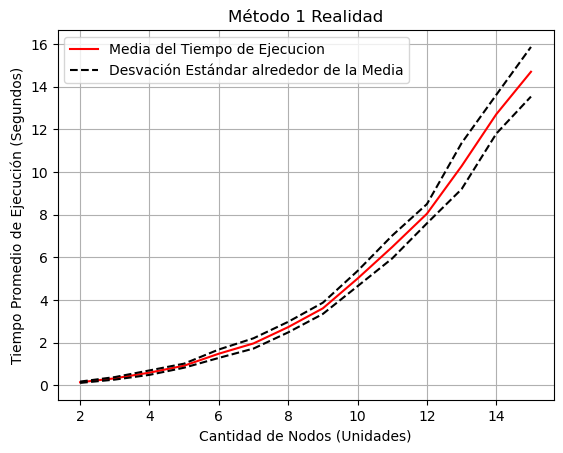

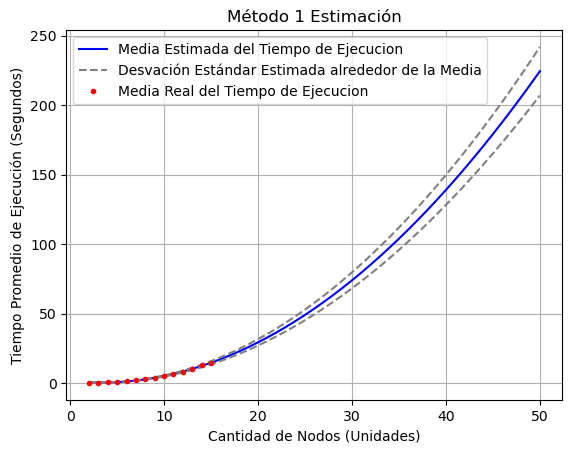

In [9]:
graph_individual_time_complexity(times_lagrange_method_1, title='Método 1 Realidad')
graph_individual_time_complexity_approx(times_lagrange_method_1, title='Método 1 Estimación')

### Método 2

En este caso `fun_sir_lagrange` recibe tanto los parámetros del modelo, como puede ser usado para evaluarlo. Por lo tanto esta función se debe utilizar directamente para buscar una solución numérica al SEDO.

In [10]:
def fun_sir_lagrange(t,y,Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)

    y.resize((4,K,K))
    I_k_i = y[1].sum(axis=0)
    N_k_i = y[3].sum(axis=0)
    new_y = np.zeros((4,K,K))
    for i in range(K):
        for j in range(K):
            if i == j:
                new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
            else:
                new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]
                                
    y.resize((4*K*K,))
    new_y.resize((4*K*K,))
    return new_y

In [11]:
'''
times_lagrange_method_2 = {}
for i, arrays_params in matrix_test_lagrange.items():
    if i > 15:
        break
    times_lagrange_method_2[i] = []
    y0 = GenerateY0_SIR_lagrange(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(fun_sir_lagrange, (0, 500), y0, args=params), number= 1)
        times_lagrange_method_2[i].append(time)
np.savez_compressed('times_lagrange_method_2', times_lagrange_method_2=times_lagrange_method_2)
'''

loaded_2 = np.load('times_lagrange_method_2.npz', allow_pickle=True)
times_lagrange_method_2 = loaded_2['times_lagrange_method_2'].reshape(-1)[0]

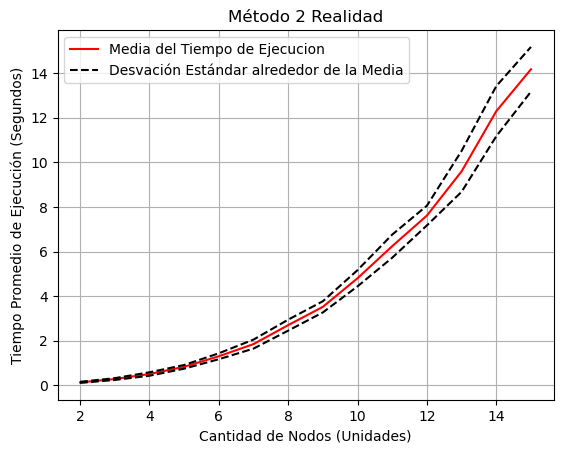

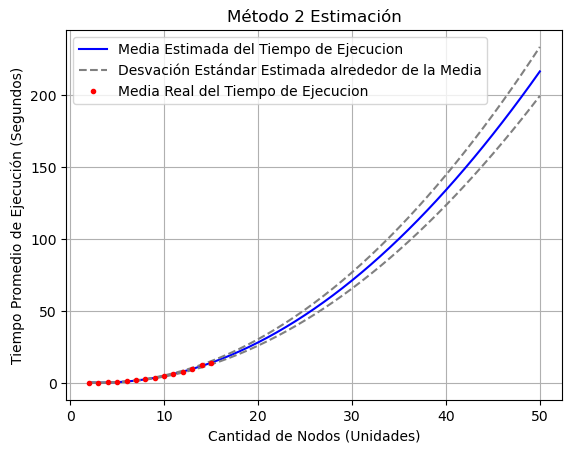

In [12]:
graph_individual_time_complexity(times_lagrange_method_2, title='Método 2 Realidad')
graph_individual_time_complexity_approx(times_lagrange_method_2, title='Método 2 Estimación')

### Método 3

Similar al **Método 1** donde ahora `gen_fun_sir_lagrange_numba` recibe los parámetros del modelo y genera una función para evaluar el modelo con estos parámetros ya insertados, pero esta función generada se decora con `njit` forzando que se compile en primera instancia. Por lo tanto una vez generada la nueva función esta es la que se debe utilizar para buscar una solución numérica al SEDO.

In [13]:
def gen_fun_sir_lagrange_numba(Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)
    @njit
    def fun(t,y):
        y = y.reshape((4,K,K))
        I_k_i = y[1].sum(axis=0)
        N_k_i = y[3].sum(axis=0)
        new_y = np.zeros((4,K,K))
        for i in range(K):
            for j in range(K):
                if i == j:
                    new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                    y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                    new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                    y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                    new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                    y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                    new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
                else:
                    new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                    In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                    new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                    In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                    new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                    In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                    new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]

        new_y = new_y.reshape((4*K*K,))
        return new_y
    return fun

In [14]:
'''
times_lagrange_method_3 = {}
for i, arrays_params in matrix_test_lagrange.items():
    if i > 5:
        break
    times_lagrange_method_3[i] = []
    y0 = GenerateY0_SIR_lagrange(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(gen_fun_sir_lagrange_numba(*params), (0, 500), y0), number= 1)
        times_lagrange_method_3[i].append(time)
np.savez_compressed('times_lagrange_method_3', times_lagrange_method_3=times_lagrange_method_3)
'''

loaded_3 = np.load('times_lagrange_method_3.npz', allow_pickle=True)
times_lagrange_method_3 = loaded_3['times_lagrange_method_3'].reshape(-1)[0]

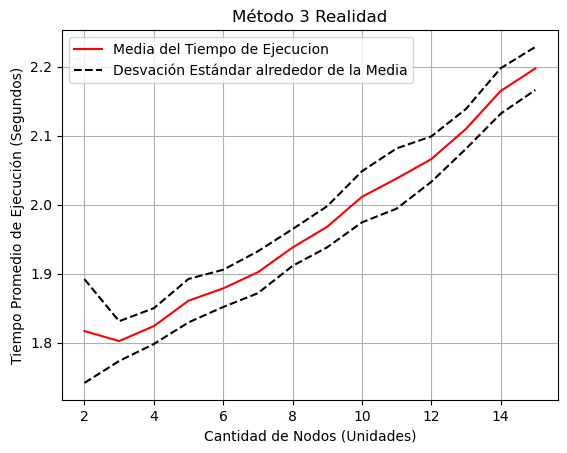

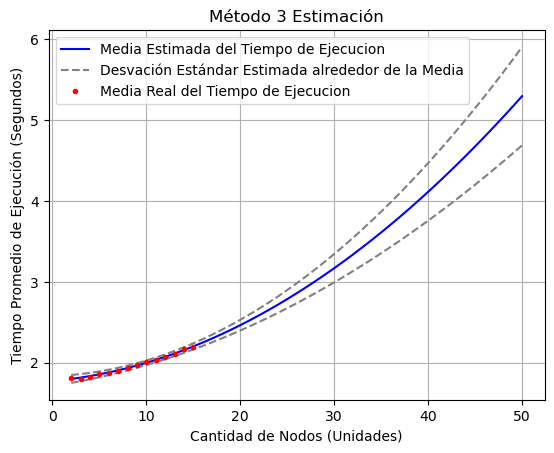

In [15]:
graph_individual_time_complexity(times_lagrange_method_3, title='Método 3 Realidad')
graph_individual_time_complexity_approx(times_lagrange_method_3, title='Método 3 Estimación')

### Método 4

Similar al **Método 2** donde en este caso `fun_sir_lagrange_numba` recibe tanto los parámetros del modelo, como puede ser usado para evaluarlo, pero se utiliza `njit` para decorarla y trabajar con una versión compilada de esta. Por lo tanto esta función se debe utilizar directamente para buscar una solución numérica al SEDO.

In [16]:
@njit
def fun_sir_lagrange_numba(t,y,Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)

    y = y.reshape((4,K,K))
    I_k_i = y[1].sum(axis=0)
    N_k_i = y[3].sum(axis=0)
    new_y = np.zeros((4,K,K))
    for i in range(K):
        for j in range(K):
            if i == j:
                new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
            else:
                new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]

    new_y = new_y.reshape((4*K*K,))
    return new_y

In [17]:
'''
times_lagrange_method_4 = {}
for i, arrays_params in matrix_test_lagrange.items():
    if i > 15:
        break
    times_lagrange_method_4[i] = []
    y0 = GenerateY0_SIR_lagrange(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(fun_sir_lagrange_numba, (0, 500), y0, args=params), number= 1)
        times_lagrange_method_4[i].append(time)
np.savez_compressed('times_lagrange_method_4', times_lagrange_method_4=times_lagrange_method_4)
'''

loaded_4 = np.load('times_lagrange_method_4.npz', allow_pickle=True)
times_lagrange_method_4 = loaded_4['times_lagrange_method_4'].reshape(-1)[0]

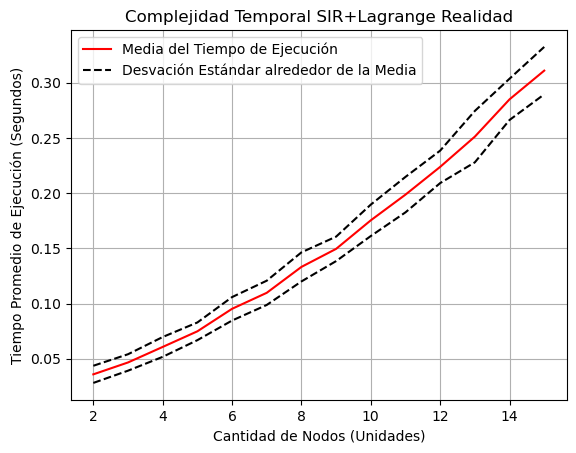

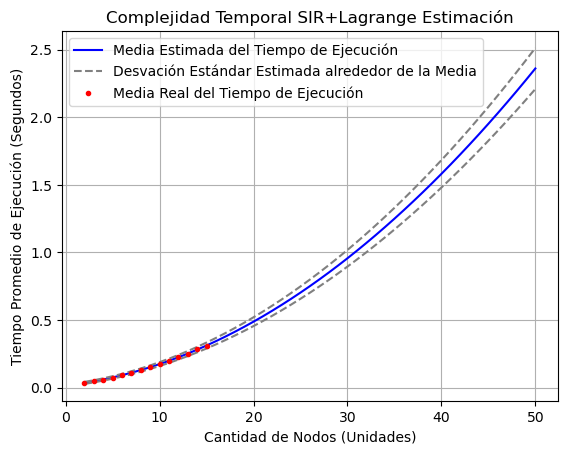

In [30]:
graph_individual_time_complexity(times_lagrange_method_4, title='Complejidad Temporal SIR+Lagrange Realidad')
graph_individual_time_complexity_approx(times_lagrange_method_4, title='Complejidad Temporal SIR+Lagrange Estimación')

## Resumen

Para finalizar ilustramos todas las curvas de complejidad temporal real simuladas, para facilitar la comparación de estas. Así destacamos, la superioridad de los **Métodos 3 y 4** que utilizan la compilación `JIT`. Mientras que para los **Métodos 1 y 2** aunque la curva de creciemiento es más acelerada, ambas no tienen mucha diferencias entre ellas. Sin embargo algo que llama mucho la atención es el tiempo adicional que toma el **Método 3** con respecto al **Método 4**, donde para generar dinámicamente la función que deseamos compilar consume un tiempo extra, que empeora mucho la complejidad cuando se compara con el último Método.

In [100]:
def graph_many_time_complexity(arrays_times_method, names):
    for i, times_method in enumerate(arrays_times_method):
        means = []
        stdevs = []
        ts = []
        for t, times in times_method.items():
            means.append(mean(times))
            stdevs.append(stdev(times))
            ts.append(t)
        if names:
            plt.plot(ts, means, label = names[i])
        else:
            plt.plot(ts, means, label = f'Método {i+1}')
        plt.xlabel('Cantidad de Nodos (Unidades)')
        plt.ylabel('Tiempo Promedio de Ejecución (Segundos)')
        plt.title('Media del Tiempo de Ejecución')
    plt.grid()
    plt.legend()
    plt.show()

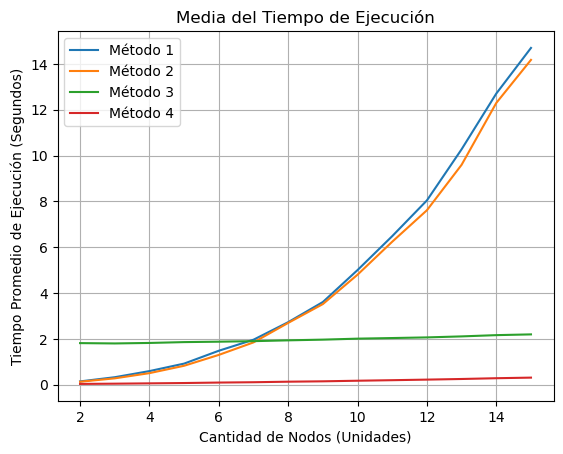

In [24]:
graph_many_time_complexity([
    times_lagrange_method_1,
    times_lagrange_method_2,
    times_lagrange_method_3,
    times_lagrange_method_4,
])

In [21]:
import pandas as pd

Ks = np.linspace(2,15,14)
df = pd.DataFrame(columns=Ks, dtype=float)
df = df.append(pd.Series(Ks, index=Ks,name='Holi'), ignore_index=True, )
df = df.append(pd.Series(Ks, index=Ks,name='Hola'), ignore_index=True)
df

/tmp/ipykernel_314662/3661051975.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(Ks, index=Ks,name='Holi'), ignore_index=True, )
/tmp/ipykernel_314662/3661051975.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(Ks, index=Ks,name='Hola'), ignore_index=True)


,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
1,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0


In [111]:
import pandas as pd

def table_many_time_complexity(arrays_times_method):
    Ks = np.linspace(2,15,14)
    df = pd.DataFrame(columns=Ks, dtype=float)

    for i, times_method in enumerate(arrays_times_method):
        means = []
        stdevs = []
        ts = []
        for t, times in times_method.items():
            means.append(mean(times))
            stdevs.append(stdev(times))
        df = df.append(pd.Series(means, index=Ks), ignore_index=True)
        #df = df.append(pd.Series(stdevs, index=Ks), ignore_index=True)
    return df

print(table_many_time_complexity([
        #times_lagrange_method_1,
        #times_lagrange_method_2,
        #times_lagrange_method_3,
        {k:v for k, v in times_euler_2.items() if k<16},
        times_lagrange_method_4
    ]).T.to_latex()
)

\begin{tabular}{lrr}
\toprule
{} &         0 &         1 \\
\midrule
2.0  &  0.024201 &  0.035878 \\
3.0  &  0.034192 &  0.046637 \\
4.0  &  0.042008 &  0.060702 \\
5.0  &  0.054339 &  0.074839 \\
6.0  &  0.063237 &  0.095219 \\
7.0  &  0.073623 &  0.109705 \\
8.0  &  0.088150 &  0.133164 \\
9.0  &  0.097561 &  0.149499 \\
10.0 &  0.101398 &  0.175353 \\
11.0 &  0.108969 &  0.198625 \\
12.0 &  0.127678 &  0.223760 \\
13.0 &  0.164389 &  0.251134 \\
14.0 &  0.154583 &  0.284901 \\
15.0 &  0.167450 &  0.310891 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_314662/584199664.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(means, index=Ks), ignore_index=True)
/tmp/ipykernel_314662/584199664.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(means, index=Ks), ignore_index=True)
/tmp/ipykernel_314662/584199664.py:24: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ]).T.to_latex()


La siguiente tabla muestra los tiempos promedio de los métodos anteriores según la cantidad de nodos.

|  Métodos  |       2.0 |       3.0 |       4.0 |       5.0 |       6.0 |      7.0 |      8.0 |      9.0 |     10.0 |     11.0 |    12.0 |      13.0 |      14.0 |      15.0 |
|---:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|---------:|---------:|---------:|--------:|----------:|----------:|----------:|
|  1 | 0.145337  | 0.328384  | 0.59568   | 0.92258   | 1.48367   | 1.96527  | 2.73017  | 3.6105   | 5.0046   | 6.48552  | 8.04469 | 10.2758   | 12.7072   | 14.698    |
|  2 | 0.131396  | 0.279462  | 0.506211  | 0.828301  | 1.30249   | 1.84798  | 2.69847  | 3.51996  | 4.80328  | 6.24203  | 7.61537 |  9.59812  | 12.2973   | 14.1761   |
|  3 | 1.8168    | 1.80225   | 1.82394   | 1.86079   | 1.87864   | 1.90201  | 1.93787  | 1.96801  | 2.01132  | 2.03783  | 2.06596 |  2.10979  |  2.1647   |  2.19735  |
|  4 | 0.0358776 | 0.0466371 | 0.0607016 | 0.0748391 | 0.0952191 | 0.109705 | 0.133164 | 0.149499 | 0.175353 | 0.198625 | 0.22376 |  0.251134 |  0.284901 |  0.310891 |

In [89]:
@njit
def fun_SIR_EULER_SODE(t, y, F, Beta, Gamma):

    K = F.shape[0]

    y = y.reshape((4,K))
    new_y = np.zeros((4,K))
    for i in range(K):
        new_y[0,i] = - Beta[i] * y[0,i] * y[1,i] / y[3,i]
        new_y[1,i] = Beta[i] * y[0,i] * y[1,i] / y[3,i] - Gamma[i] * y[1,i]
        new_y[2,i] = Gamma[i] * y[1,i]
        for j in range(K):
            new_y[0,i] += F[j,i] * y[0,j] - F[i,j] * y[0,i]
            new_y[1,i] += F[j,i] * y[1,j] - F[i,j] * y[1,i]
            new_y[2,i] += F[j,i] * y[2,j] - F[i,j] * y[2,i]
            new_y[3,i] += F[j,i] * y[3,j] - F[i,j] * y[3,i]
    new_y = new_y.reshape((4*K,))
    return new_y

In [83]:
def GenerateParams_SIR_EULER(K):

    F = np.random.rand(K,K)
    np.fill_diagonal(F,0)
    F = F #/ K
    Beta = np.random.rand(K)
    Gamma = np.random.rand(K)
    return F, Beta, Gamma

def GenerateY0_SIR_EULER(K):
    y0 = np.zeros((4,K))
    y0[3] = np.zeros(K) + 2000
    y0[1] = np.zeros(K) + 5
    y0[0] = np.zeros(K) + 1995
    y0.resize((4*K,))
    return y0

def GenerateParams_SIR_LAGRANGE(K):

    Out = np.random.rand(K,K)
    np.fill_diagonal(Out,0)
    Out = Out / K

    In = np.zeros((K,K)) + 1
    np.fill_diagonal(In,0)
    #In = In / K

    Beta = np.random.rand(K)
    Gamma = np.random.rand(K)

    return Out, In, Beta, Gamma

In [84]:
matrix_test_euler = {}
for i in range(2,30):
    matrix_test_euler[i] = []
    for j in range(30):
        params = GenerateParams_SIR_EULER(K = i)
        matrix_test_euler[i].append(params)

In [87]:
times_euler= {}
for i, arrays_params in matrix_test_euler.items():
    if i>15:
        break
    times_euler[i] = []
    y0 = GenerateY0_SIR_EULER(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(fun_SIR_EULER_SODE, (0, 500), y0, args=params), number= 1)
        times_euler[i].append(time)

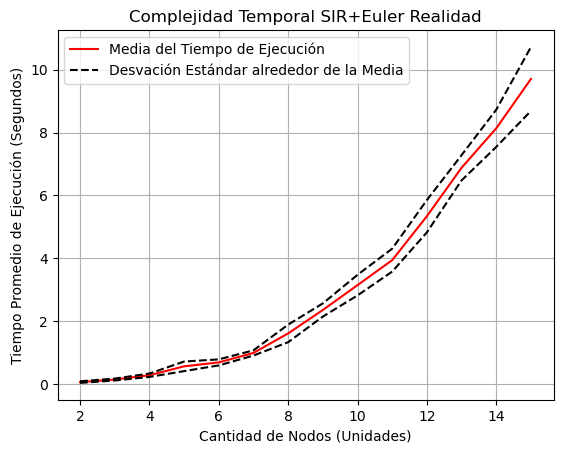

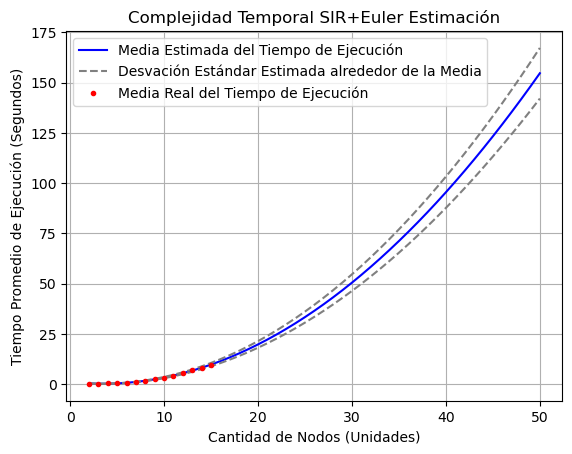

In [95]:
graph_individual_time_complexity(times_euler, title='Complejidad Temporal SIR+Euler Realidad')
graph_individual_time_complexity_approx(times_euler, title='Complejidad Temporal SIR+Euler Estimación')

In [92]:
times_euler_2= {}
for i, arrays_params in matrix_test_euler.items():
    if i>30:
        break
    times_euler_2[i] = []
    y0 = GenerateY0_SIR_EULER(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(fun_SIR_EULER_SODE, (0, 500), y0, args=params), number= 1)
        times_euler_2[i].append(time)

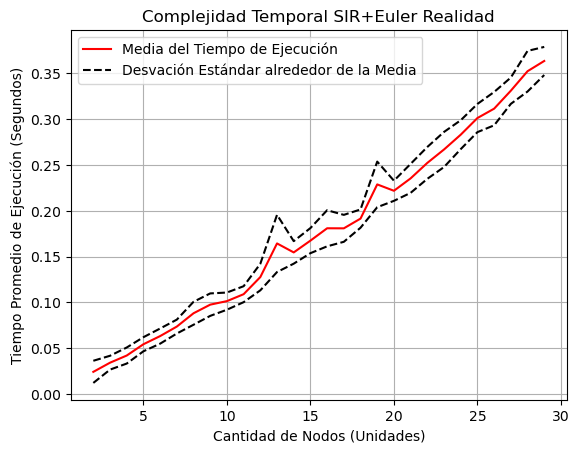

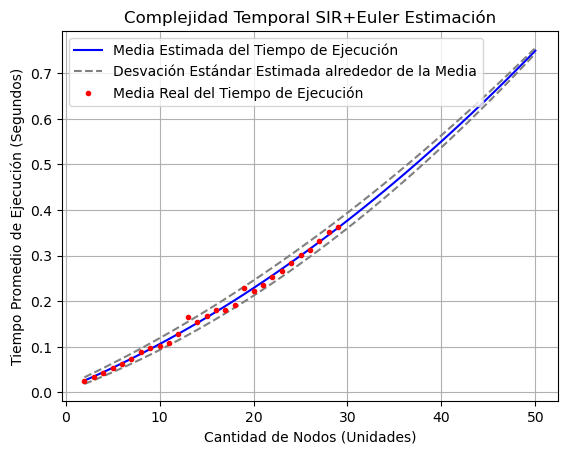

In [93]:
graph_individual_time_complexity(times_euler_2, title='Complejidad Temporal SIR+Euler Realidad')
graph_individual_time_complexity_approx(times_euler_2, title='Complejidad Temporal SIR+Euler Estimación')

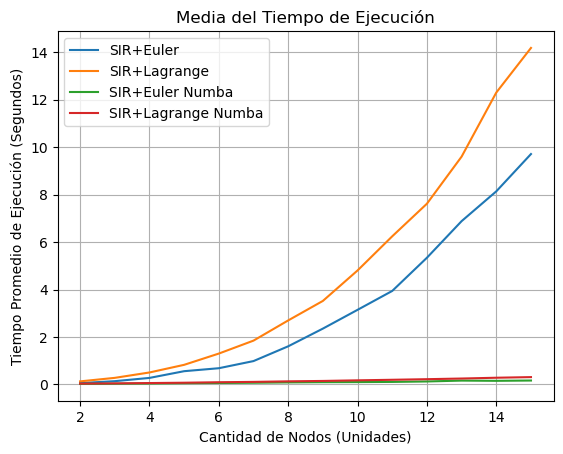

In [112]:
graph_many_time_complexity([
    #times_lagrange_method_1,
    #times_lagrange_method_3,
    times_euler,
    times_lagrange_method_2,
    {k:v for k, v in times_euler_2.items() if k<16},
    times_lagrange_method_4,
], ['SIR+Euler', 'SIR+Lagrange', 'SIR+Euler Numba', 'SIR+Lagrange Numba'])